In [1]:
import dlc_bci as bci
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F


## Import data

In [2]:
train_input, train_target = bci.load(root ="./data_bci")
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())
test_input, test_target = bci.load(root ="./data_bci", train = False)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())


<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


## Normalize data

In [3]:
train_input = (train_input - torch.mean(train_input,1,keepdim=True))/torch.std(train_input,1,True)
test_input = (test_input - torch.mean(test_input,1,keepdim=True))/torch.std(test_input,1,True)

Number of training samples = 316
Number of testing samples = 100
Number of channels = 28
Number of readings per channel = 50


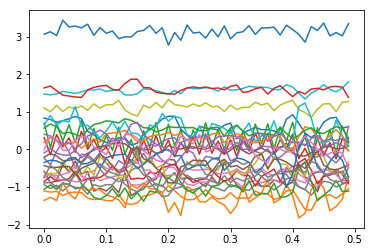

In [4]:
n_train_samples = train_target.size()[0]
print('Number of training samples = {}'.format(n_train_samples))
n_test_samples = test_target.size()[0]
print('Number of testing samples = {}'.format(n_test_samples))
n_channels = train_input.size()[1]
print('Number of channels = {}'.format(n_channels))
n_readings = train_input.size()[2]
print('Number of readings per channel = {}'.format(n_readings))

freq = 100

tt = np.arange(0,0.5,1/freq)

for i in range(n_channels):
    plt.plot(tt,train_input[0,i,:].numpy())

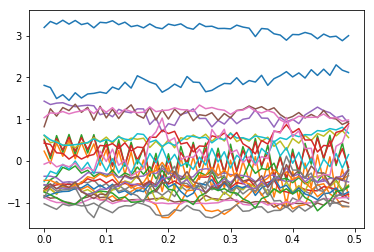

In [5]:
for i in range(n_channels):
    plt.plot(tt,train_input[1,i,:].numpy())

## Define Network

In [42]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 32, (1, 50), padding = (0,16)) # Apply convolution on each channels
        self.batchnorm1 = nn.BatchNorm2d(32, False) # Normalize
        
        # Layer 2
        self.conv2 = nn.Conv2d(32,32,(28, 1)) # Apply one convolution on each timestamp
        self.batchnorm2 = nn.BatchNorm2d(32, False) # Normalize
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(32*33,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.batchnorm1(x)
        #print("Shape after first Convolution : {}".format(x.shape))
        x = self.conv2(x)
        x = F.elu(self.batchnorm2(x))
        #print("Shape after secondConvolution : {}".format(x.shape))
        x = F.dropout2d(x,0.25)
        x = x.view(-1,32*33)
        #print("Flatten shape for FC : {}".format(x.shape))
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.dropout(x,0.25)
        x = F.elu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        #print("Output format : {}".format(x.shape))
        
        return x

## Train

In [43]:
net = MyNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [44]:
def accuracy(Yh, Y, n_samples): 
    
    Yh.round()
    correct = (Yh.data == Y.data)[0].sum()
    return 100* correct / n_samples
    
def Validate(model, criterion, X, Y):
    
    val_loss = 0.0
    model.eval()
    Yh = model(X)
    val_loss = criterion(Yh, Y).data[0]
    val_acc = accuracy(Yh,Y,len(Y))
    
    print("Validation Loss = {0:.3}".format(val_loss))
    print("Validation accuracy = {0:.3}".format(val_acc))
    
    return val_loss

In [45]:
batch_size = 70
n_epochs = 100
n_validation_samples = 36

train_err = []
val_err = []

for epoch in range(n_epochs):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    accuracy_score = []
    roc_auc_score = []
    
    
    val_idx = random.sample(range(n_train_samples), n_validation_samples)
    train_idx = np.delete(np.arange(n_train_samples),val_idx)
    X_val = Variable(torch.unsqueeze(train_input[torch.LongTensor(val_idx)],1))
    Y_val = Variable(train_target[torch.LongTensor(val_idx)].type(torch.FloatTensor))
    
    
    data = train_input[torch.LongTensor(train_idx)]
    target = train_target[torch.LongTensor(train_idx)]
    
    train_loss = 0.0
    train_acc = 0.0
    for i in range(int(len(data)/batch_size)):
        s = i*batch_size
        e = (i+1)*batch_size
        
        inputs = torch.unsqueeze(data[s:e],1)
        #print("train input shape : {}".format(inputs.shape))
        labels = target[s:e].type(torch.FloatTensor)
        #print("train target shape : {}".format(labels.shape))
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_acc += accuracy(outputs, labels, batch_size)
        train_loss += loss.data[0]
        
    print("Training Loss = {0:.3}".format(train_loss))
    print("Training accuracy = {0:.3}".format(train_acc))
    
    
    
    train_err.append(train_loss)
    val_err.append(Validate(net, criterion, X_val, Y_val))


Epoch  0


/home/dave/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  1
Training Loss = 2.01
Training accuracy = 1.99e+02
Validation Loss = 0.5
Validation accuracy = 50.0

Epoch  2
Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  3
Training Loss = 2.04
Training accuracy = 1.96e+02
Validation Loss = 0.444
Validation accuracy = 55.6

Epoch  4
Training Loss = 2.04
Training accuracy = 1.96e+02
Validation Loss = 0.444
Validation accuracy = 55.6

Epoch  5
Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  6
Training Loss = 1.94
Training accuracy = 2.06e+02
Validation Loss = 0.639
Validation accuracy = 36.1

Epoch  7
Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  8
Training Loss = 2.07
Training accuracy = 1.93e+02
Validation Loss = 0.389
Validation accuracy = 61.1

Epoch  9
Training Loss = 1.9

Training Loss = 1.96
Training accuracy = 2.04e+02
Validation Loss = 0.611
Validation accuracy = 38.9

Epoch  75
Training Loss = 2.01
Training accuracy = 1.99e+02
Validation Loss = 0.5
Validation accuracy = 50.0

Epoch  76
Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  77
Training Loss = 2.06
Training accuracy = 1.94e+02
Validation Loss = 0.417
Validation accuracy = 58.3

Epoch  78
Training Loss = 2.0
Training accuracy = 2e+02
Validation Loss = 0.528
Validation accuracy = 47.2

Epoch  79
Training Loss = 2.03
Training accuracy = 1.97e+02
Validation Loss = 0.472
Validation accuracy = 52.8

Epoch  80
Training Loss = 2.04
Training accuracy = 1.96e+02
Validation Loss = 0.444
Validation accuracy = 55.6

Epoch  81
Training Loss = 2.04
Training accuracy = 1.96e+02
Validation Loss = 0.444
Validation accuracy = 55.6

Epoch  82
Training Loss = 2.01
Training accuracy = 1.99e+02
Validation Loss = 0.5
Validation accuracy = 50.0

Epoch  83
Trai

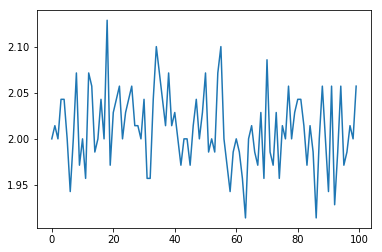

In [46]:
plt.plot(np.arange(n_epochs), train_err)

In [47]:
Validate(net, criterion, Variable(torch.unsqueeze(test_input,1)), Variable(test_target.type(torch.FloatTensor)))


Validation Loss = 0.49
Validation accuracy = 51.0


/home/dave/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.49000000953674316

In [48]:
net(Variable(torch.unsqueeze(test_input,1)))

/home/dave/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Variable containing:
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
[torch.FloatTensor of size 100x1]